<a href="https://colab.research.google.com/github/laxmisahu12/Human-Expression-Classification-Project/blob/main/EmotionDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive
print("Mounting Google Drive...")
from google.colab import drive, files
drive.mount('/content/drive')
print("Google Drive mounted successfully!")

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully!


In [ ]:
# Install required packages
import subprocess, sys
def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])
try:
    import cv2
except ImportError:
    install('opencv-python-headless')
    import cv2
!pip install opencv-python-headless
!pip install tensorflow
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import joblib
import warnings
from IPython.display import display, Javascript, HTML
from google.colab.output import eval_js
from base64 import b64decode
import PIL.Image as Image
import io
warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)


In [ ]:
# Set emotion labels and paths
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
num_classes = len(emotion_labels)
DATASET_PATH = "/content/drive/MyDrive/Images_dataset"
TRAIN_DIR = f"/content/drive/MyDrive/Images_dataset/train"
TEST_DIR = f"/content/drive/MyDrive/Images_dataset/test"
print(f"Dataset Path: {DATASET_PATH}\nTrain Directory: {TRAIN_DIR}\nTest Directory: {TEST_DIR}")

img_height = 48
img_width = 48

Dataset Path: /content/drive/MyDrive/Images_dataset
Train Directory: /content/drive/MyDrive/Images_dataset/train
Test Directory: /content/drive/MyDrive/Images_dataset/test


In [ ]:
# === DATASET VERIFICATION ===
if not os.path.exists(TRAIN_DIR):
    print(f"❌ Training directory not found: {TRAIN_DIR}")
    verified = False
elif not os.path.exists(TEST_DIR):
    print(f"❌ Testing directory not found: {TEST_DIR}")
    verified = False
else:
    missing_emotions = []
    for emotion in emotion_labels:
        train_emotion_path = os.path.join(TRAIN_DIR, emotion)
        test_emotion_path = os.path.join(TEST_DIR, emotion)
        if not os.path.exists(train_emotion_path):
            missing_emotions.append(f"train/{emotion}")
        if not os.path.exists(test_emotion_path):
            missing_emotions.append(f"test/{emotion}")
    if missing_emotions:
        print(f"❌ Missing emotion folders: {missing_emotions}")
        verified = False
    else:
        print("✅ Train and test directories found!")
        print("✅ All emotion folders found!")
        verified = True

✅ Train and test directories found!
✅ All emotion folders found!


# === DATASET ANALYSIS + LOADING ===

In [ ]:
# Analyze train/test distributions
train_stats = {};  test_stats = {}
print("\n=== DATASET ANALYSIS ===")

print("\nTraining Set:")
for emotion in emotion_labels:
    emotion_path = os.path.join(TRAIN_DIR, emotion)
    count = len(os.listdir(emotion_path)) if os.path.exists(emotion_path) else 0
    train_stats[emotion] = count
    print(f"  {emotion.capitalize()}: {count} images")
print("\nTesting Set:")
for emotion in emotion_labels:
    emotion_path = os.path.join(TEST_DIR, emotion)
    count = len(os.listdir(emotion_path)) if os.path.exists(emotion_path) else 0
    test_stats[emotion] = count
    print(f"  {emotion.capitalize()}: {count} images")
total_train = sum(train_stats.values())
total_test = sum(test_stats.values())
print(f"\nTotal Training Images: {total_train}\nTotal Testing Images: {total_test}")
print(f"Total Dataset Size: {total_train + total_test}")


=== DATASET ANALYSIS ===

Training Set:
  Angry: 200 images
  Disgust: 200 images
  Fear: 200 images
  Happy: 200 images
  Sad: 200 images
  Surprise: 200 images
  Neutral: 200 images

Testing Set:
  Angry: 100 images
  Disgust: 100 images
  Fear: 100 images
  Happy: 100 images
  Sad: 100 images
  Surprise: 100 images
  Neutral: 100 images

Total Training Images: 1400
Total Testing Images: 700
Total Dataset Size: 2100


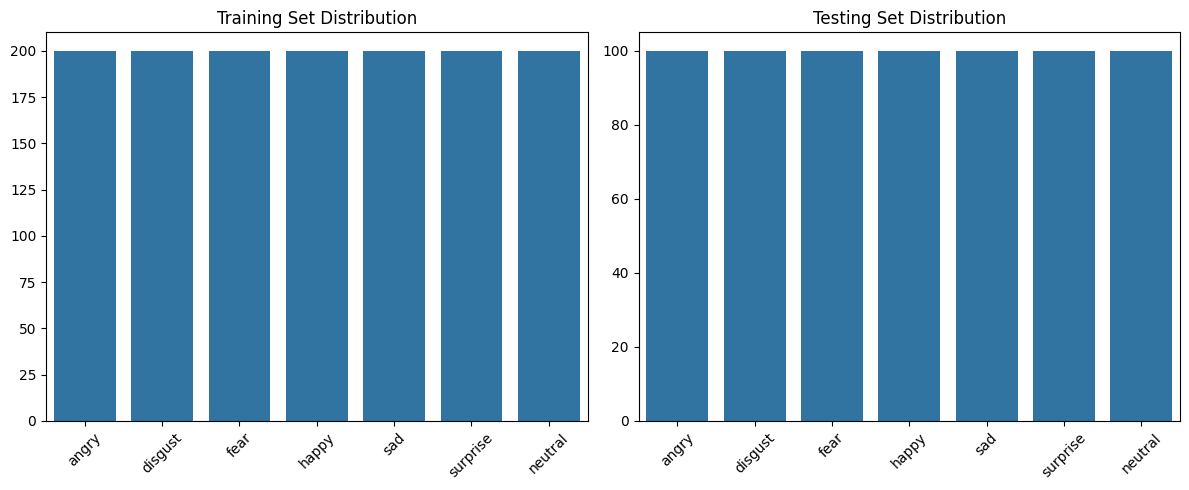

In [ ]:
# Plot distributions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(x=list(train_stats.keys()), y=list(train_stats.values()))
plt.title('Training Set Distribution'); plt.xticks(rotation=45)
plt.subplot(1, 2, 2)
sns.barplot(x=list(test_stats.keys()), y=list(test_stats.values()))
plt.title('Testing Set Distribution'); plt.xticks(rotation=45)
plt.tight_layout(); plt.show()

In [ ]:
# Load data as numpy arrays
def load_images_from_directory(directory, split_name, img_height, img_width):
    images, labels = [], []
    for label_idx, emotion in enumerate(emotion_labels):
        emotion_path = os.path.join(directory, emotion)
        if os.path.exists(emotion_path):
            for img_name in os.listdir(emotion_path):
                img_path = os.path.join(emotion_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img = cv2.resize(img, (img_width, img_height))
                    images.append(img)
                    labels.append(label_idx)
    images = np.array(images)
    labels = np.array(labels)
    if len(images.shape) == 3:
        images = images.reshape(images.shape[0], img_height, img_width, 1)
    return images, labels
print("\n=== LOADING DATASET ===")
X_train, y_train = load_images_from_directory(TRAIN_DIR, "Training", img_height, img_width)
X_test, y_test = load_images_from_directory(TEST_DIR, "Testing", img_height, img_width)
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)
print(f"✅ Training data shape: {X_train.shape}")
print(f"✅ Testing data shape: {X_test.shape}")


=== LOADING DATASET ===
✅ Training data shape: (1400, 48, 48, 1)
✅ Testing data shape: (700, 48, 48, 1)


In [ ]:
# === BUILD IMPROVED CNN MODEL ===
print("\n=== BUILDING IMPROVED CNN MODEL ===")
cnn_model = Sequential([
    Conv2D(64, (5, 5), activation='relu', padding='same', input_shape=(img_height, img_width, 1)),
    BatchNormalization(),
    Conv2D(64, (5, 5), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
print("✅ Improved CNN Model built successfully!")
cnn_model.summary()


=== BUILDING IMPROVED CNN MODEL ===
✅ Improved CNN Model built successfully!


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 48, 48, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 48, 48, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │     9,438,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,183,303 (42.66 MB)

 Trainable params: 11,180,359 (42.65 MB)

 Non-trainable params: 2,944 (11.50 KB)


=== TRAINING IMPROVED CNN MODEL ===
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 131s 6s/step - accuracy: 0.1692 - loss: 2.7903 - val_accuracy: 0.1457 - val_loss: 2.4086 - learning_rate: 0.0010
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.2031 - loss: 2.8130 - val_accuracy: 0.1429 - val_loss: 2.3832 - learning_rate: 0.0010
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 123s 6s/step - accuracy: 0.1404 - loss: 2.6884 - val_accuracy: 0.1486 - val_loss: 2.4944 - learning_rate: 0.0010
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.2031 - loss: 2.3541 - val_accuracy: 0.1629 - val_loss: 2.5329 - learning_rate: 0.0010
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 175s 6s/step - accuracy: 0.1523 - loss: 2.5726 - val_accuracy: 0.1543 - val_loss: 2.6709 - learning_rate: 0.0010
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 648ms/step - accuracy: 0.1406 - loss: 2.7858 - val_accuracy: 0.1500 - val_loss: 2.7525 - learning_rate: 0.0010
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 115s 6s/step - accu

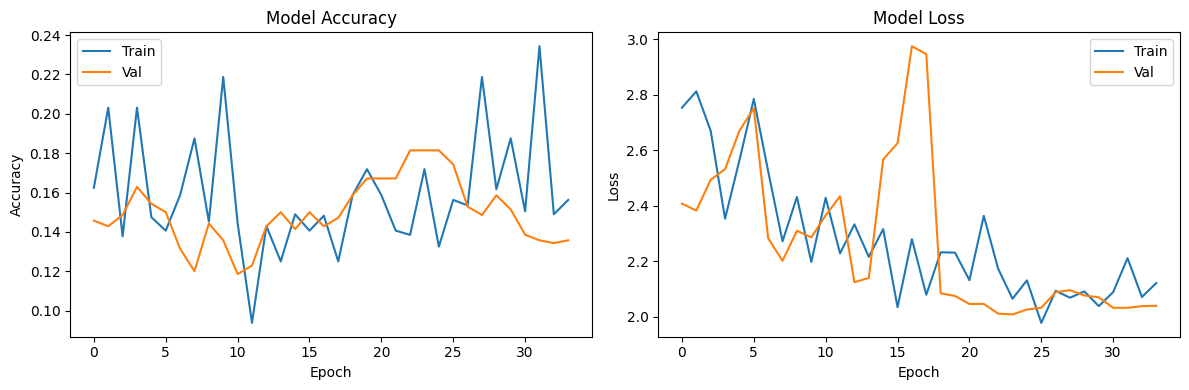

✅ Improved CNN model saved: /content/drive/MyDrive/facial_expression_cnn_model_improved.h5


In [ ]:
# === TRAIN IMPROVED CNN ===
print("\n=== TRAINING IMPROVED CNN MODEL ===")
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    zoom_range=0.3,
    shear_range=0.2,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
history = cnn_model.fit(
    datagen.flow(X_train, y_train_cat, batch_size=64), # Increased batch size
    steps_per_epoch=len(X_train)//64, # Adjusted steps per epoch
    epochs=50, # Increased epochs
    validation_data=(X_test, y_test_cat),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy'); plt.ylabel('Accuracy'); plt.xlabel('Epoch')
plt.legend(['Train', 'Val'])
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss'); plt.ylabel('Loss'); plt.xlabel('Epoch')
plt.legend(['Train', 'Val'])
plt.tight_layout()
plt.show()
model_path = '/content/drive/MyDrive/facial_expression_cnn_model_improved.h5' # Changed model name
cnn_model.save(model_path)
print(f"✅ Improved CNN model saved: {model_path}")


=== EVALUATING IMPROVED CNN MODEL ===


✅ Loaded best CNN model from: /content/drive/MyDrive/best_facial_expression_cnn_model.h5
Improved CNN Test Accuracy: 0.1514
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 604ms/step

Improved CNN Classification Report:
               precision    recall  f1-score   support

       angry       0.00      0.00      0.00       100
     disgust       0.21      0.03      0.05       100
        fear       0.00      0.00      0.00       100
       happy       0.16      0.85      0.26       100
         sad       0.00      0.00      0.00       100
    surprise       0.13      0.18      0.15       100
     neutral       0.00      0.00      0.00       100

    accuracy                           0.15       700
   macro avg       0.07      0.15      0.07       700
weighted avg       0.07      0.15      0.07       700



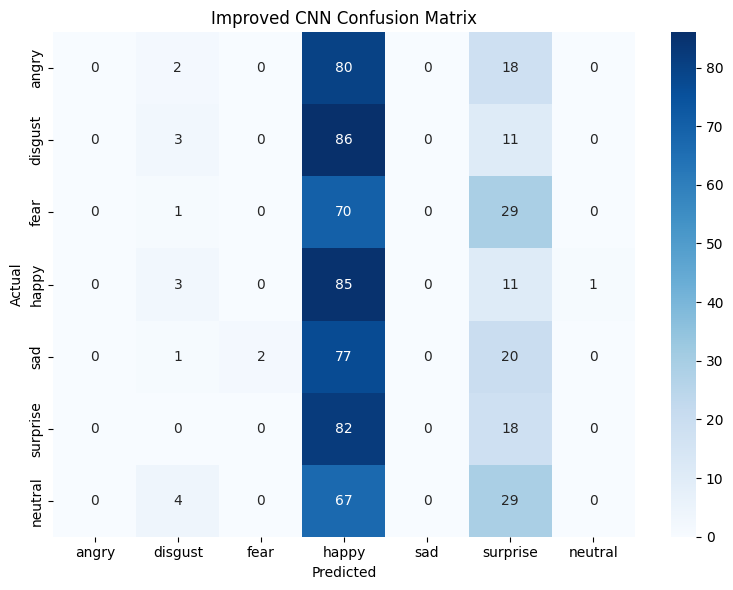

In [ ]:
# === EVALUATE IMPROVED CNN MODEL ===
print("\n=== EVALUATING IMPROVED CNN MODEL ===")
best_cnn_model_path = '/content/drive/MyDrive/best_facial_expression_cnn_model.h5'
try:
    improved_cnn_model = load_model(best_cnn_model_path)
    print(f"✅ Loaded best CNN model from: {best_cnn_model_path}")
    cnn_loss, cnn_accuracy = improved_cnn_model.evaluate(X_test, y_test_cat, verbose=0)
    print(f"Improved CNN Test Accuracy: {cnn_accuracy:.4f}")
    cnn_predictions = improved_cnn_model.predict(X_test)
    cnn_pred_labels = np.argmax(cnn_predictions, axis=1)
    print("\nImproved CNN Classification Report:\n", classification_report(y_test, cnn_pred_labels, target_names=emotion_labels))
    cm_cnn = confusion_matrix(y_test, cnn_pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
    plt.title('Improved CNN Confusion Matrix')
    plt.xlabel('Predicted'); plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"❌ Error loading or evaluating model: {e}")

In [ ]:
# --- TESTING CODE (run separately as required) ---
# To test a single image by upload (change model_type to 'cnn' or 'svm'):
print("Upload an image to test with the model:")
uploaded = files.upload()
if uploaded:
    image_path = list(uploaded.keys())[0]
    model_type = 'cnn'  # or 'svm'

    if model_type == 'cnn':
        model_path = '/content/drive/MyDrive/best_facial_expression_cnn_model.h5' # Load the best CNN model
        try:
            model = load_model(model_path)
            print(f"✅ Loaded CNN model from: {model_path}")
        except Exception as e:
            print(f"❌ Error loading CNN model: {e}")
            model = None # Set model to None if loading fails
    else:
        model_path = '/content/drive/MyDrive/facial_expression_svm_model.pkl'
        try:
            model = joblib.load(model_path)
            scaler = joblib.load('/content/drive/MyDrive/svm_scaler.pkl')
            pca = joblib.load('/content/drive/MyDrive/svm_pca.pkl')
            print(f"✅ Loaded SVM model from: {model_path}")
        except Exception as e:
             print(f"❌ Error loading SVM model or related components: {e}")
             model = None # Set model to None if loading fails

    if model is not None: # Proceed only if model loaded successfully
        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        img = cv2.imread(image_path)
        if img is not None:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, 1.3, 5)
            if len(faces) == 0:
                print("❌ No faces detected")
            else:
                plt.figure(figsize=(12, 8))
                for i, (x, y, w, h) in enumerate(faces):
                    face_roi = gray[y:y+h, x:x+w]
                    face_in = cv2.resize(face_roi, (48, 48))
                    if model_type == 'cnn':
                        face_proc = face_in.astype('float32') / 255.0
                        face_proc = face_proc.reshape(1, 48, 48, 1)
                        pred = model.predict(face_proc)
                        emo_idx = np.argmax(pred)
                        confidence = pred[0][emo_idx]
                    else:
                        face_proc = face_in.astype('float32') / 255.0
                        face_proc = face_proc.flatten().reshape(1, -1)
                        face_proc = scaler.transform(face_proc)
                        face_proc = pca.transform(face_proc)
                        pred = model.predict_proba(face_proc)
                        emo_idx = np.argmax(pred)
                        confidence = pred[0][emo_idx]
                    emotion = emotion_labels[emo_idx]
                    cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 3)
                    label = f"{emotion}: {confidence:.2f}"
                    cv2.putText(img, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)
                    print(f"Face {i+1}: {emotion} (confidence: {confidence:.2f})")
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.imshow(img_rgb)
                plt.title('Emotion Detection Results')
                plt.axis('off')
                plt.show()
        else:
            print("❌ Could not load image")
    else:
        print("❌ Model not loaded. Cannot proceed with testing.") # Message if model loading failed